In [1]:
import numpy as np
print(f"{'numpy':<11} {np.__version__:<6}")

import pandas as pd
print(f"{'pandas':<11} {pd.__version__:<6}")

import matplotlib
print(f"{'matplotlib':<11} {matplotlib.__version__:<6}")

import matplotlib.pyplot as plt

from sklearn import __version__ as sklearn_version
print(f"{'sklearn':<11} {sklearn_version:<6}")

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, recall_score

import itertools

numpy       1.19.1
pandas      1.1.3 
matplotlib  3.3.1 
sklearn     0.23.2


In [2]:
from sklearn import set_config
set_config(display="diagram")

In [3]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

def print_report( Y_test, Y_preds ):
    print('MAE                                         : %.3f'% mean_absolute_error(Y_test, Y_preds))
    print('Precision                                   : %.3f'% precision_score(Y_test, Y_preds))
    print('Recall                                      : %.3f'% recall_score(Y_test, Y_preds))
    print('F1-Score                                    : %.3f'% f1_score(Y_test, Y_preds))
    print('\nPrecision Recall F1-Score Support Per Class : \n', precision_recall_fscore_support(Y_test, Y_preds))
    print('\nClassification Report                       : ')
    print(classification_report(Y_test, Y_preds))

In [4]:
# Model Evaluation
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot( Y_test, Y_preds ):

    conf_mat = confusion_matrix(Y_test, Y_preds)
    print(conf_mat)
    with plt.style.context(('ggplot', 'seaborn')):
        fig = plt.figure(figsize=(6,6), num=1)
        plt.imshow(conf_mat, interpolation='nearest',cmap= plt.cm.Blues )
        plt.xticks([0,1],[0,1])
        plt.yticks([0,1],[0,1])
        plt.xlabel('Predicted Label')
        plt.ylabel('Actual Label')
        for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
                    plt.text(j, i,conf_mat[i, j], horizontalalignment="center",color="red")
        plt.grid(None)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.show()

In [5]:
# Data Loading
df0: pd.DataFrame = pd.read_csv(
    "datasets/traffic_AR_CL_UY+features+column_classifier.csv",
    parse_dates=["Fecha"]
)

df0["Fecha"] = pd.to_datetime(df0["Fecha"], utc=True)


In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7712 entries, 0 to 7711
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Fecha                7712 non-null   datetime64[ns, UTC]
 1   Site                 7712 non-null   object             
 2   flow                 7712 non-null   object             
 3   Device               7712 non-null   object             
 4   Loading              7712 non-null   int64              
 5   Shipping             7712 non-null   int64              
 6   Payments             7712 non-null   int64              
 7   Review               7712 non-null   int64              
 8   Congrats             7712 non-null   int64              
 9   missing              7712 non-null   bool               
 10  day_of_week          7712 non-null   int64              
 11  month                7712 non-null   int64              
 12  year                

In [7]:
site   = "MLA"
flow   = "direct"
device = "iOS"

result: pd.DataFrame = df0.query(
        f""" Site == "{site}" and flow == '{flow}' and Device == '{device}' """
    )


In [8]:
# Column / Feature Selection
data = result[["Fecha", "Site", "flow","Device","Loading","Shipping","Payments","Review","Congrats","TOTAL","anomaly"]]


In [9]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 7 to 7701
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Fecha     488 non-null    datetime64[ns, UTC]
 1   Site      488 non-null    object             
 2   flow      488 non-null    object             
 3   Device    488 non-null    object             
 4   Loading   488 non-null    int64              
 5   Shipping  488 non-null    int64              
 6   Payments  488 non-null    int64              
 7   Review    488 non-null    int64              
 8   Congrats  488 non-null    int64              
 9   TOTAL     488 non-null    float64            
 10  anomaly   488 non-null    bool               
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(5), object(3)
memory usage: 42.4+ KB


False    0.915984
True     0.084016
Name: anomaly, dtype: float64


<AxesSubplot:title={'center':'Classes distribution'}>

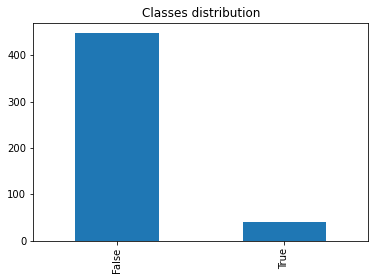

In [10]:
print(data.anomaly.value_counts(normalize=True))
data["anomaly"].value_counts().plot(kind="bar", title="Classes distribution")


In [11]:
map_class = { 
    True : 1,  # Anomalies on class 1
    False: -1  # Normal on class -1
}

data["class"] = data["anomaly"].map(map_class)

target_name = "class"
target = data[target_name]
target

/Users/contingencia/miniconda3/envs/ddatos21_ment_tp3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


7      -1
19     -1
31      1
43     -1
55     -1
       ..
7629    1
7647   -1
7665   -1
7683    1
7701   -1
Name: class, Length: 488, dtype: int64

In [12]:
# We drop from our data the target column to train our 
data = data.drop( columns = [ target_name , "anomaly" ] )
data.head()

,Fecha,Site,flow,Device,Loading,Shipping,Payments,Review,Congrats,TOTAL
7,2019-03-01 00:00:00+00:00,MLA,direct,iOS,29215,27378,23245,17899,16835,0.615
19,2019-03-02 00:00:00+00:00,MLA,direct,iOS,22275,20572,17103,12304,11421,0.555
31,2019-03-03 00:00:00+00:00,MLA,direct,iOS,18784,17220,13968,9617,8865,0.515
43,2019-03-04 00:00:00+00:00,MLA,direct,iOS,24166,22199,18156,12852,11881,0.535
55,2019-03-05 00:00:00+00:00,MLA,direct,iOS,29237,27081,22501,16484,15372,0.568


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.15, random_state=999983)

# display(X_train)
# display(y_train)

In [14]:
# define individual transformers in a pipeline
categorical_preprocessing = Pipeline([
    ('ohe', OneHotEncoder())
])
numerical_preprocessing = Pipeline([
    ('imputation', SimpleImputer()),
    ('scaler', StandardScaler())
])

# define which transformer applies to which columns
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ["Site", "flow","Device"]),
    ('numerical_preprocessing', numerical_preprocessing, ["Loading","Shipping","Payments","Review","Congrats","TOTAL"])
])

# define clasifier
outliers_fraction = 0.09
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.02)

# create the final pipeline with preprocessing steps and 
# the final classifier step
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('clf', model )
])

pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['Site', 'flow', 'Device']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Loading', 'Shipping',
                                                   'Payments', 'Review',
                                                   'Congrats', 'TOTAL'])])),
                ('clf', OneClassSVM(gamma=0.02, nu=0.09))])

5515   -1
7355   -1
6043    1
5627   -1
6811   -1
       ..
3659   -1
2235   -1
411    -1
5531   -1
6603   -1
Name: class, Length: 74, dtype: int64

array([ 1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
       -1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1])

[[ 7 58]
 [ 2  7]]


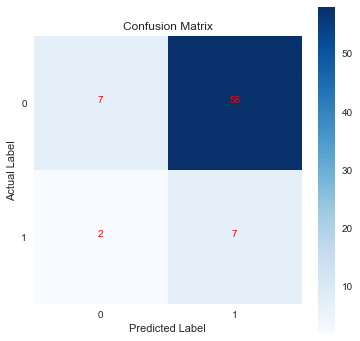

MAE                                         : 1.622
Precision                                   : 0.108
Recall                                      : 0.778
F1-Score                                    : 0.189

Precision Recall F1-Score Support Per Class : 
 (array([0.77777778, 0.10769231]), array([0.10769231, 0.77777778]), array([0.18918919, 0.18918919]), array([65,  9]))

Classification Report                       : 
              precision    recall  f1-score   support

          -1       0.78      0.11      0.19        65
           1       0.11      0.78      0.19         9

    accuracy                           0.19        74
   macro avg       0.44      0.44      0.19        74
weighted avg       0.70      0.19      0.19        74



In [15]:
#Realizamos el ajuste
pipeline.fit(X_train,y_train)

# evaluate the model against test data
yhat = pipeline.predict(X_test)

display(y_test)
display(yhat)

# evaluate predictions
confusion_matrix_plot(y_test, yhat)
print_report( y_test, yhat )
#


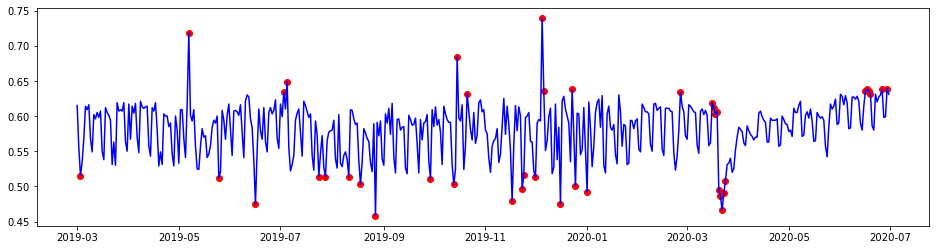

In [16]:

fig, ax = plt.subplots(figsize=(16,4))
a = result.loc[ result["anomaly"] == 1 , ["Fecha" , "TOTAL"] ] #anomaly

ax.plot(result["Fecha"], result["TOTAL"], color='blue')
ax.scatter(a["Fecha"],a["TOTAL"], color='red')

plt.show();